In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.io import savemat, loadmat
import matlab.engine # to run Cheng's code
import time

# add the path to my packages to system paths so they can be imported
import sys
sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages')
# sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

import my_simgraph_06 as sg
import data_handler_03 as dh
import edge_selection_cheng_01 as es

# Create training and validation datasets

In [140]:
data_sz = 13204 # all available mnist-sift datapoints
# consider all range
ind_min = 0
ind_max = 13203
train_num = 30
val_num = 20

# # load all the labels
# data_path = '../../data/fe_exp/mnist-sift/'
# lbls = np.loadtxt(data_path+'lbls.csv')

def transform(fv):
    return fv[::63]

def get_mnist_labels(data_params):
    return np.loadtxt(data_params['features_dp']+'lbls.csv')

data_params = {'func': dh.datapoint_sift, 'lbl_func': get_mnist_labels, 'features_dp': '../../data/fe_exp/mnist-sift/', \
               'spike_data': None, 'group_id': None, 'transform': transform, 'ind_min': 0, 'ind_max': 13203}

train_num, val_num, train_data, val_data = \
dh.random_train_val_balanced(train_num, val_num, data_params, seed=None)

# show statistics
print('train_num = ', train_num, ', val_num = ', val_num)
print('# of features = ', train_data['des'].shape[1])
print('training data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(train_data['lbls'] == 1), np.sum(train_data['lbls'] == 1)*100/train_num))
print('validation data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(val_data['lbls'] == 1), np.sum(val_data['lbls'] == 1)*100/val_num))

# print('train_smpls = ', train_data['smpls'], '\nval_smpls = ', val_data['smpls'])
# print('train_lbls = ', train_data['lbls'], '\nval_lbls = ', val_data['lbls'])
# print('train_des = ', train_data['des'], '\nval_des = ', val_data['des'])

train_num =  30 , val_num =  20
# of features =  5
training data contains 15 points (50.00%) of label 1.
validation data contains 10 points (50.00%) of label 1.


## Select training edges

In [112]:
def get_edges_tt_maxdeg_cheng(x, D, seed):
    """
    Refer to documentation for 'get_edges_tt'
    """

    if seed is not None:
        np.random.seed(seed)

    edges = []
    N = x.shape[0]
    degree = np.zeros(N)
    for i in range(N):
        candids = []
        for j in range(i+1, N):
            if degree[j] < D:
                candids.append(j)
        candids = np.array(candids)
        
        temp = np.array([],dtype=np.int64)
        comp = D-degree[i];
        if comp < len(candids):
            if comp > 0 and any(x[candids]==x[i]):
                chosen = candids[x[candids]==x[i]][0]
                temp = np.append(temp, chosen)
                comp = comp - 1
                candids = candids[candids != chosen]
            if comp > 0 and any(x[candids]!=x[i]):
                chosen = candids[x[candids]!=x[i]][0]
                temp = np.append(temp, chosen)
                comp = comp - 1
                candids = candids[candids != chosen]
            temp = np.append(temp, np.random.choice(candids, size=int(comp), replace=False))
        else:
            temp = np.array(candids)

        temp = [(i,j) for j in temp] 
        edges = edges + temp
        degree[i] += len(temp)
        for (i,j) in temp:
            degree[j] += 1

    return edges

In [113]:
# graph construction and penalty term parameters
# NOTE: Dt must be greater than one to make sure at least one delta variable exists in the objective function
sg_params = {'mu': 30, 'Dt': 5000, 'Dv': 0, 'Dvt': 3000, \
             'cnstr_method_tt': 'random', 'cnstr_method_vv': 'random', 'cnstr_method_vt': 'random',\
             'train_t': train_data['smpls'], 'val_t': val_data['smpls'], \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

In [114]:
# construct the training graph
seed = 0
if sg_params['edges_tt'] is None:
    sg_params['edges_tt'] = get_edges_tt_maxdeg_cheng(train_data['lbls'], sg_params['Dt'], seed)

In [115]:
print('number of tt edges: ', len(sg_params['edges_tt']))

number of tt edges:  435


## Save the data on disc for the Matlab code's use

In [116]:
# save the dataset on disc
data_path = '../../data/fe_exp/cheng_swap_1/'
savemat(data_path+'data_sift.mat', {'data_feature': train_data['des'], 'data_label': train_data['lbls'], 'data_edge': sg_params['edges_tt']})

# Learn the similarity graph with GDPA

In [86]:
eng.quit()

In [87]:
eng = matlab.engine.start_matlab()
eng.cd(r'../15_cheng/lmnn-offtheshelf/', nargout=0)

In [117]:
gamma = 1
beta = 1
# (M_gdpa, delta_gdpa) = eng.lmnn_fit('sift',gamma, beta, nargout=2)
(M_gdpa, delta_gdpa, cvx_status) = eng.lmnn_cvx_python('sift',gamma, beta, nargout=3)

In [118]:
M_gdpa = np.array(M_gdpa)
delta_gdpa = np.array(delta_gdpa).reshape(-1)

In [119]:
delta_gdpa

array([0.18978289, 0.59344635, 0.84038793, ..., 1.19256253, 1.50519813,
       1.43888346])

## Display learned metric matrix

Text(0.5, 1.0, 'M_gdpa - marked above 0%')

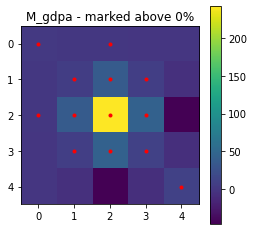

In [120]:
# display the optimized metric matrix
# print('M_gdpa = \n', M_gdpa)

sg.display_matrix(M_gdpa, None)
# mark elements with high values
thresh = 0
lim = (thresh/100) * np.max(M_gdpa) # marker threshold
f_sz = M_gdpa.shape[0]
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
plt.plot(xloc[M_gdpa > lim],yloc[M_gdpa > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M_gdpa - marked above {}%'.format(thresh))
# print('M_gdpa - Coordinates of elements with higher values than {}'.format(lim))
# print(list(zip(xloc[M_gdpa > lim],yloc[M_gdpa > lim])))

In [121]:
M_dummy = M_gdpa.copy()
M_dummy[np.eye(train_data['des'].shape[1]).astype(bool)] = 0
print('Is there any non-zero element off-diagonal: ', (M_dummy > 0).any())

Is there any non-zero element off-diagonal:  True


## Compute the final training loss of sg-gdpa

In [122]:
V = eng.get_objective_variables_ready_python('sift')
V = np.array(V)

In [123]:
loss_gdpa = np.sum(M_gdpa * V.T) + beta * np.sum(delta_gdpa)

print('GDPA loss with GDPA metric: {:.4f}'.format(loss_gdpa))

GDPA loss with GDPA metric: 2300.2248


## Validate the similarity graph (GDPA)

In [124]:
# # reload sg package
# import importlib
# importlib.reload(sg)

In [125]:
val_acc_gdpa, y_est_gdpa, t_gdpa = sg.get_acc(M_gdpa, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], sg_params, seed=seed, show_edges=False)
print('Elapsed time = {:.2f} ms'.format(t_gdpa*1000))

Elapsed time = 3.99 ms


In [126]:
# Note: sg_params changes here. edges_vv and edges_vt are set

In [127]:
print('val acc = {:.2f}%'.format(val_acc_gdpa*100))
print('elapsed time = {:.2f} ms'.format(t_gdpa*1000))
print('estimated val labels = ', 2*(y_est_gdpa>0).astype(np.int32)-1)

val acc = 90.00%
elapsed time = 3.99 ms
estimated val labels =  [ 1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1]


In [128]:
# comparing estimated and real spike locations
val_loc = np.arange(val_num)
val_spikes = val_loc[val_data['lbls']==1]
est_spikes_gdpa = val_loc[y_est_gdpa > 0]

if sum(val_data['lbls']==1) == 0:
    missed_gdpa = 0
else:
    missed_gdpa = sum(np.logical_and(val_data['lbls']==1, y_est_gdpa < 0))/sum(val_data['lbls']==1)

if sum(val_data['lbls']==-1) == 0:
    false_alarm_gdpa = 0
else:
    false_alarm_gdpa = sum(np.logical_and(val_data['lbls']==-1, y_est_gdpa > 0))/sum(val_data['lbls']==-1)

nospk_per = np.sum(val_data['lbls']==-1)/val_num
min_acc = max(nospk_per, 1-nospk_per)

print('Estimated spike time bins: ', est_spikes_gdpa)
print('Real spike time bins: ', val_spikes)
print('{:.2f}% of validation points have label {} (= min accuracy)'.format(min_acc*100, -1 if nospk_per > 50 else 1))
print('Missed spikes (/all spikes): {:.2f}%'.format(missed_gdpa*100))
print('False spikes (/all no-spike bins): {:.2f}%'.format(false_alarm_gdpa*100))

Estimated spike time bins:  [ 0  1  2  3  4  5  6  7  8  9 10 15]
Real spike time bins:  [0 1 2 3 4 5 6 7 8 9]
50.00% of validation points have label 1 (= min accuracy)
Missed spikes (/all spikes): 0.00%
False spikes (/all no-spike bins): 20.00%


# Train the similarity graph with M = B.T @ B

In [129]:
# graph construction and penalty term parameters
# sg_params = {'mu': 30, 'Dt': None, 'Dv':0, 'Dvt':2000, \
#              'cnstr_method_tt': 'time', 'cnstr_method_vv': 'time', 'cnstr_method_vt': 'time',\
#              'train_t': train_data['smpls'], 'val_t': val_data['smpls'], \
#              'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters
sg_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 2, \
                  'num_its':10, 'check_freq':1, 'print_checks':True, 'Theta0':None, \
                  'force_all_its': True, 'threshold': 0.01}

time0 = time.time()
B_fact, sg_stats_fact = sg.fit_graph(dess=train_data['des'], lbls=train_data['lbls'], graph_params=sg_params, opt_params=sg_opt_params, seed=0)
print('Elapsed time = {} sec'.format(time.time()-time0))

Number of training datapoints: 30
Number of features for each point: 5
mu = 30
   0: eps = 3.12e-02;  train loss (E) = 1740.00
   1: eps = 3.12e-02;  train loss (E) = 1739.99
   2: eps = 6.25e-02;  train loss (E) = 1739.96
   3: eps = 6.25e-02;  train loss (E) = 1739.90
   4: eps = 3.12e-02;  train loss (E) = 1739.64
   5: eps = 6.25e-02;  train loss (E) = 1739.01
   6: eps = 6.25e-02;  train loss (E) = 1738.59
   7: eps = 3.12e-02;  train loss (E) = 1735.02
   8: eps = 3.12e-02;  train loss (E) = 1732.04
   9: eps = 3.12e-02;  train loss (E) = 1730.35
Elapsed time = 0.10172748565673828 sec


## Display learned metric matrix

Text(0.5, 1.0, 'M_fact - marked above 30%')

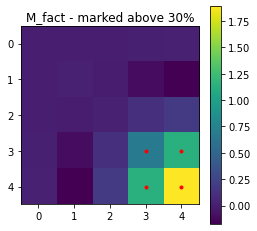

In [130]:
# display learned M
M_fact = B_fact.T @ B_fact

sg.display_matrix(M_fact, None)

# mark elements with high values
thresh = 30
lim = (thresh/100) * np.max(M_fact) # marker threshold
f_sz = M_fact.shape[0]
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
plt.plot(xloc[M_fact > lim],yloc[M_fact > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M_fact - marked above {}%'.format(thresh))
# print('M_fact - Coordinates of elements with higher values than {:.2f}'.format(lim))
# print(list(zip(xloc[M_fact > lim],yloc[M_fact > lim])))

## Compute the final training loss of sg-factorization

In [131]:
loss_fact = sg.cnstr_glr(B_fact, deriv=False, mu=sg_params['mu'], x=train_data['lbls'], F=train_data['des'].T, edges_tt=sg_params['edges_tt'])

print('Factorization final loss: {:.3f}'.format(loss_fact))

Factorization final loss: 1730.348


## Validate the similarity graph

In [132]:
val_acc_fact, y_est_fact, t_fact = sg.get_acc(M_fact, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], sg_params, seed=seed, show_edges=False)

In [133]:
print('val acc = {:.2f}%'.format(val_acc_fact*100))
print('elapsed time = {:.2f} ms'.format(t_fact*1000))
print('estimated val labels = ', 2*(y_est_fact>0).astype(np.int32)-1)

val acc = 50.00%
elapsed time = 2.99 ms
estimated val labels =  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [134]:
# comparing estimated and real spike locations
est_spikes_fact = val_loc[y_est_fact > 0]

if sum(val_data['lbls']==1) == 0:
    missed_fact = 0
else:
    missed_fact = sum(np.logical_and(val_data['lbls']==1, y_est_fact < 0))/sum(val_data['lbls']==1)

if sum(val_data['lbls']==-1) == 0:
    false_alarm_fact = 0
else:
    false_alarm_fact = sum(np.logical_and(val_data['lbls']==-1, y_est_fact > 0))/sum(val_data['lbls']==-1)

nospk_per = np.sum(val_data['lbls']==-1)/val_num
min_acc = max(nospk_per, 1-nospk_per)

print('Estimated spike time bins: ', est_spikes_fact)
print('Real spike time bins: ', val_spikes)
print('{:.2f}% of validation points have label {} (= min accuracy)'.format(min_acc*100, -1 if nospk_per > 50 else 1))
print('Missed spikes (/all spikes): {:.2f}%'.format(missed_fact*100))
print('False spikes (/all no-spike bins): {:.2f}%'.format(false_alarm_fact*100))

Estimated spike time bins:  []
Real spike time bins:  [0 1 2 3 4 5 6 7 8 9]
50.00% of validation points have label 1 (= min accuracy)
Missed spikes (/all spikes): 100.00%
False spikes (/all no-spike bins): 0.00%


# Train the logistic regression model

In [135]:
# instantiate the model
lgrg = LogisticRegression(penalty='none')

# train the model  
lgrg = lgrg.fit(train_data['des'], train_data['lbls'])

In [136]:
# print optimized parameters
print('classes = ', lgrg.classes_)
# print('decision boundary coefficients = ', lgrg.coef_)
print('decision boundary bias = ', lgrg.intercept_)
print('number of features seen during fit = ', lgrg.n_features_in_)
print('number of iterations done during fit = ', lgrg.n_iter_)

classes =  [-1.  1.]
decision boundary bias =  [-198.44273107]
number of features seen during fit =  5
number of iterations done during fit =  [27]


## Validate the logistic regression

In [137]:
# validate the model
preds_lgrg = lgrg.predict(val_data['des'])
val_acc_lgrg = lgrg.score(val_data['des'], val_data['lbls'])

est_spikes_lgrg = val_loc[preds_lgrg > 0]
if sum(val_data['lbls']==1) == 0:
    missed_lgrg = 0
else:
    missed_lgrg = sum(np.logical_and(val_data['lbls']==1, preds_lgrg < 0))/sum(val_data['lbls']==1)
if sum(val_data['lbls']==-1) == 0:
    false_alarm_lgrg = 0
else:
    false_alarm_lgrg = sum(np.logical_and(val_data['lbls']==-1, preds_lgrg > 0))/sum(val_data['lbls']==-1)

print('Predicted labels WITH threshold =\n', preds_lgrg)
print('Validation accuracy = {:.2f}%\n'.format(val_acc_lgrg*100))
print('Estimated spike time bins: ', est_spikes_lgrg)
print('Real spike time bins: ', val_spikes)
print('Missed spikes (/all spikes): {:.2f}%'.format(missed_lgrg*100))
print('False spikes (/all no-spike bins): {:.2f}%'.format(false_alarm_lgrg*100))

Predicted labels WITH threshold =
 [ 1.  1.  1.  1.  1. -1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.]
Validation accuracy = 95.00%

Estimated spike time bins:  [0 1 2 3 4 6 7 8 9]
Real spike time bins:  [0 1 2 3 4 5 6 7 8 9]
Missed spikes (/all spikes): 10.00%
False spikes (/all no-spike bins): 0.00%


## Substitute the factorization M into the GDPA objective

In [138]:
loss_fact = sg.cnstr_glr(B_fact, deriv=False, mu=sg_params['mu'], x=train_data['lbls'], F=train_data['des'].T, edges_tt=sg_params['edges_tt'])
loss_gdpa = np.sum(M_gdpa * V.T) + beta * np.sum(delta_gdpa)
loss_fact_in_gdpa = np.sum(M_fact * V.T) + beta * np.sum(delta_gdpa)

print('Factorization loss with factorization metric: {:.3f}'.format(loss_fact))
print('GDPA loss with GDPA metric: ', loss_gdpa)
print('GDPA loss with Factorization metric: ', loss_fact_in_gdpa)

Factorization loss with factorization metric: 1730.348
GDPA loss with GDPA metric:  2300.224844792662
GDPA loss with Factorization metric:  2217.511300812661


In [139]:
print('GDPA val acc = {:.2f}%'.format(val_acc_gdpa*100))
print('Factorization val acc = {:.2f}%'.format(val_acc_fact*100))
print('Logistic regression validation accuracy = {:.2f}%\n'.format(val_acc_lgrg*100))

GDPA val acc = 90.00%
Factorization val acc = 50.00%
Logistic regression validation accuracy = 95.00%



# Quite the matlab engine (otherwise would overuse RAM)

In [48]:
eng.quit()